In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import datetime as dt
import time 
import seaborn as sns 
from matplotlib.ticker import PercentFormatter
import calendar
import matplotlib.ticker as ticker
from PIL import * 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf

### Koba Table

In [2]:
ci = [1.0 , 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]
mslp = [1005, 1002, 998, 993, 987, 981, 973, 965, 956, 947,937, 926, 914, 901, 888]
mws = [22, 29, 36, 43, 50, 57, 64, 71, 78, 85, 93, 100, 107, 115, 122]

[  -1.52230123   -3.07071752 1009.9489011 ]


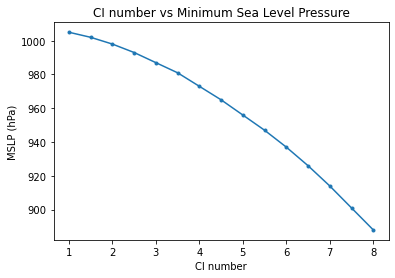

In [3]:
plt.plot(ci, mslp, ".-")
plt.title("CI number vs Minimum Sea Level Pressure")
plt.xlabel("CI number")
plt.ylabel("MSLP (hPa)")
z1 = np.polyfit(ci, mslp, 2)
print(z1)

[14.27142857  7.2452381 ]


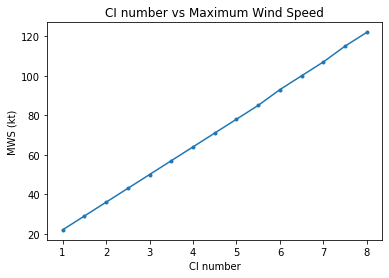

In [4]:
plt.plot(ci, mws, ".-")
plt.title("CI number vs Maximum Wind Speed")
plt.xlabel("CI number")
plt.ylabel("MWS (kt)")
z2 = np.polyfit(ci, mws, 1)
print(z2)

### Conversion table

In [5]:
def pres_to_ci(p): #pressure in mb or hPa
    ci_num = [1.0 , 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]
    mslp = [1005, 1002, 998, 993, 987, 981, 973, 965, 956, 947,937, 926, 914, 901, 888]
    z1 = np.polyfit(ci_num, mslp, 2)
    ci = (-z1[1] - np.sqrt((z1[1])**2 - 4*(z1[0])*(z1[2]-p)))/(2*z1[0]) 
    return ci

def ci_to_wind(c): #wind speed in kt 
    ci_num = [1.0 , 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]
    mws = [22, 29, 36, 43, 50, 57, 64, 71, 78, 85, 93, 100, 107, 115, 122]
    z2 = np.polyfit(ci_num, mws,1)
    max_w = (z2[0]*c) + z2[1]
    return max_w

def pres_to_wind(p):
    ci_num = [1.0 , 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]
    mslp = [1005, 1002, 998, 993, 987, 981, 973, 965, 956, 947,937, 926, 914, 901, 888]
    mws = [22, 29, 36, 43, 50, 57, 64, 71, 78, 85, 93, 100, 107, 115, 122]
    
    z1 = np.polyfit(ci_num, mslp, 2)
    ci = (-(-3.07071752) - np.sqrt((-3.07071752)**2 - 4*((-1.52230123))*((1009.9489011)-p)))/(2*(-1.52230123))
    
    z2 = np.polyfit(ci_num, mws,1)
    max_w = ((14.27142857)*ci) + 7.2452381 
    
    return max_w
    

### Filtering IBTrACS data

In [6]:
# IBTRaCS data contains TC data from various meteorological agencies 
# Limit the data to JMA TC data only from 1951 up to present

#df = pd.read_csv(r'ibtracs.WP.list.v04r00.V2.csv') #reads the whole ibtracs csv data
df = pd.read_csv(r'ibtracsWP_2021_updated.csv')
df = df.loc[1:,:] #remove the first row in the csv file 
season = df.SEASON.astype("float64") #convert the data type to float first
df = df[(season >= 1951) & (season <= 2021)] #obtain the data from 1951 onwards 

C:\Users\Mae\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,2,8,9,14,131,132,133,161,162) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
df

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
68180,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 06:00:00,TS,20.0,138.5,...,,,,,,,,,9,225
68181,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 09:00:00,TS,19.6732,138.152,...,,,,,,,,,0,0
68182,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 12:00:00,TS,20.0,138.5,...,,,,,,,,,24,46
68183,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 15:00:00,TS,21.3532,139.999,...,,,,,,,,,45,48
68184,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 18:00:00,TS,23.0,142.1,...,,,,,,,,,46,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240746,2021351N04104,2021,100,WP,MM,NOT_NAMED,2021-12-17 06:00:00,NR,4.1,102.0,...,,,,,,,,,8,266
240747,2021351N04104,2021,100,WP,MM,NOT_NAMED,2021-12-17 09:00:00,NR,4.09245,101.705,...,,,,,,,,,5,270
240748,2021351N04104,2021,100,WP,MM,NOT_NAMED,2021-12-17 12:00:00,NR,4.1,101.5,...,,,,,,,,,4,271
240749,2021351N04104,2021,100,WP,MM,NOT_NAMED,2021-12-17 15:00:00,NR,4.10253,101.302,...,,,,,,,,,4,270


### JMA

In [8]:
dat = df[df.columns[0:17]]
tokyo_dat = df[df.columns[42:54]]
jma_dat = dat.join(tokyo_dat)
jma_dat.SID.nunique()

2689

In [17]:
tokyo_dat

,TOKYO_LAT,TOKYO_LON,TOKYO_GRADE,TOKYO_WIND,TOKYO_PRES,TOKYO_R50_DIR,TOKYO_R50_LONG,TOKYO_R50_SHORT,TOKYO_R30_DIR,TOKYO_R30_LONG,TOKYO_R30_SHORT,TOKYO_LAND
68180,20.0000,138.500,2,,1010,0,,,0,,,0
68181,19.6732,138.152,2,,1010,0,,,0,,,
68182,20.0000,138.500,2,,1010,0,,,0,,,0
68183,21.3532,139.999,2,,1005,0,,,0,,,
68184,23.0000,142.100,2,,1000,0,,,0,,,0
...,...,...,...,...,...,...,...,...,...,...,...,...
240746,,,,,,,,,,,,
240747,,,,,,,,,,,,
240748,,,,,,,,,,,,
240749,,,,,,,,,,,,


In [9]:
#filtering out rows where the tokyo_pres column value is either null/nan or larger than 1011 hPa
# wind data starts from 1977 so conversion from pressure to max wind is needed

jma_dat = jma_dat.replace(" ", np.nan) #replace empty cells by NaN to remove errors in dtype conversion
jma_dat = jma_dat.dropna(subset = ["TOKYO_PRES"]) #remove corresponding rows of the NAN tokyo pressure values 
jma_dat.head()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,TOKYO_GRADE,TOKYO_WIND,TOKYO_PRES,TOKYO_R50_DIR,TOKYO_R50_LONG,TOKYO_R50_SHORT,TOKYO_R30_DIR,TOKYO_R30_LONG,TOKYO_R30_SHORT,TOKYO_LAND
68180,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 06:00:00,TS,20.0000,138.500,...,2,NaN,1010,0,NaN,NaN,0,NaN,NaN,0
68181,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 09:00:00,TS,19.6732,138.152,...,2,NaN,1010,0,NaN,NaN,0,NaN,NaN,NaN
68182,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 12:00:00,TS,20.0000,138.500,...,2,NaN,1010,0,NaN,NaN,0,NaN,NaN,0
68183,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 15:00:00,TS,21.3532,139.999,...,2,NaN,1005,0,NaN,NaN,0,NaN,NaN,NaN
68184,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 18:00:00,TS,23.0000,142.100,...,2,NaN,1000,0,NaN,NaN,0,NaN,NaN,0


In [10]:
#convert the data type of columns TOKYO_WIND and TOKYO_PRES

tokyo_pres = jma_dat.TOKYO_PRES.astype("float64")
jma_dat.update(tokyo_pres)

tokyo_wind = jma_dat.TOKYO_WIND.astype("float64")
jma_dat.update(tokyo_wind)

tokyo_lat = jma_dat.TOKYO_LAT.astype("float64")
jma_dat.update(tokyo_lat)

tokyo_lon = jma_dat.TOKYO_LON.astype("float64")
jma_dat.update(tokyo_lon)

jma_dat.head()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,TOKYO_GRADE,TOKYO_WIND,TOKYO_PRES,TOKYO_R50_DIR,TOKYO_R50_LONG,TOKYO_R50_SHORT,TOKYO_R30_DIR,TOKYO_R30_LONG,TOKYO_R30_SHORT,TOKYO_LAND
68180,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 06:00:00,TS,20.0000,138.500,...,2,NaN,1010.0,0,NaN,NaN,0,NaN,NaN,0
68181,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 09:00:00,TS,19.6732,138.152,...,2,NaN,1010.0,0,NaN,NaN,0,NaN,NaN,NaN
68182,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 12:00:00,TS,20.0000,138.500,...,2,NaN,1010.0,0,NaN,NaN,0,NaN,NaN,0
68183,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 15:00:00,TS,21.3532,139.999,...,2,NaN,1005.0,0,NaN,NaN,0,NaN,NaN,NaN
68184,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 18:00:00,TS,23.0000,142.100,...,2,NaN,1000.0,0,NaN,NaN,0,NaN,NaN,0


In [16]:
# remove rows where tokyo_pres value is greater than 1011 hPa

ind1011 = jma_dat[ jma_dat["TOKYO_PRES"] > 1011 ].index
jma_dat.drop(ind1011, inplace = True)
jma_dat.tail()


,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,TOKYO_GRADE,TOKYO_WIND,TOKYO_PRES,TOKYO_R50_DIR,TOKYO_R50_LONG,TOKYO_R50_SHORT,TOKYO_R30_DIR,TOKYO_R30_LONG,TOKYO_R30_SHORT,TOKYO_LAND
239343,2020353N06129,2020,111,WP,MM,KROVANH,2020-12-24 12:00:00,TS,8.15000,101.750,...,2,19.971852,1006.0,0,NaN,NaN,0,NaN,NaN,0
239344,2020353N06129,2020,111,WP,MM,KROVANH,2020-12-24 15:00:00,TS,8.37989,101.257,...,2,17.381497,1007.0,0,NaN,NaN,0,NaN,NaN,NaN
239345,2020353N06129,2020,111,WP,MM,KROVANH,2020-12-24 18:00:00,TS,8.65714,100.771,...,2,14.483145,1008.0,0,NaN,NaN,0,NaN,NaN,0
239346,2020353N06129,2020,111,WP,MM,KROVANH,2020-12-24 21:00:00,TS,9.17657,100.242,...,2,14.483145,1008.0,0,NaN,NaN,0,NaN,NaN,NaN
239347,2020353N06129,2020,111,NI,BB,KROVANH,2020-12-25 00:00:00,TS,9.74000,99.600,...,2,14.483145,1008.0,0,NaN,NaN,0,NaN,NaN,0


In [12]:
#for tokyo_wind values equal to nan: convert the corresponding tokyo_wind value to max wind
inds = jma_dat.loc[pd.isna(jma_dat.TOKYO_WIND), :].index

for i in inds:
    jma_dat.loc[i, "TOKYO_WIND"] = pres_to_wind(jma_dat.TOKYO_PRES.loc[i])

In [13]:
jma_dat.to_csv('jma_data19512021_v2.csv', index=False)

In [14]:
p = pd.read_csv("jma_data19512021_v2.csv")

In [15]:
p

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,TOKYO_GRADE,TOKYO_WIND,TOKYO_PRES,TOKYO_R50_DIR,TOKYO_R50_LONG,TOKYO_R50_SHORT,TOKYO_R30_DIR,TOKYO_R30_LONG,TOKYO_R30_SHORT,TOKYO_LAND
0,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 06:00:00,TS,20.00000,138.500,...,2,7.005759,1010.0,0,NaN,NaN,0,NaN,NaN,0.0
1,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 09:00:00,TS,19.67320,138.152,...,2,7.005759,1010.0,0,NaN,NaN,0,NaN,NaN,NaN
2,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 12:00:00,TS,20.00000,138.500,...,2,7.005759,1010.0,0,NaN,NaN,0,NaN,NaN,0.0
3,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 15:00:00,TS,21.35320,139.999,...,2,22.335500,1005.0,0,NaN,NaN,0,NaN,NaN,NaN
4,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 18:00:00,TS,23.00000,142.100,...,2,32.072294,1000.0,0,NaN,NaN,0,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126059,2020353N06129,2020,111,WP,MM,KROVANH,2020-12-24 12:00:00,TS,8.15000,101.750,...,2,19.971852,1006.0,0,NaN,NaN,0,NaN,NaN,0.0
126060,2020353N06129,2020,111,WP,MM,KROVANH,2020-12-24 15:00:00,TS,8.37989,101.257,...,2,17.381497,1007.0,0,NaN,NaN,0,NaN,NaN,NaN
126061,2020353N06129,2020,111,WP,MM,KROVANH,2020-12-24 18:00:00,TS,8.65714,100.771,...,2,14.483145,1008.0,0,NaN,NaN,0,NaN,NaN,0.0
126062,2020353N06129,2020,111,WP,MM,KROVANH,2020-12-24 21:00:00,TS,9.17657,100.242,...,2,14.483145,1008.0,0,NaN,NaN,0,NaN,NaN,NaN


### JTWC

In [22]:
df.USA_SSHS.unique()

array([-1, 0, 1, 2, 3, 4, 5, '-1', '0', '1', '2', '3', '4', '5', ' ', -5,
       '-5', -4, '-4', '-3', '-2'], dtype=object)

In [23]:
usa_sshs = df.USA_SSHS.replace(' ', np.nan)
df.update(usa_sshs)

ind = df[df["USA_SSHS"] == " "].index
df.drop(ind, inplace = True)

usa_sshs = df.USA_SSHS.astype(int)
df.update(usa_sshs)


In [26]:
dat1 = df[df.columns[0:17]]
usa_dat = df[df.columns[18:27]]
jtwc_dat = dat1.join(usa_dat)

In [28]:
jtwc_dat = jtwc_dat.replace(" ", np.nan)

usa_lat = jtwc_dat.USA_LAT.astype("float64")
jtwc_dat.update(usa_lat)

usa_lon = jtwc_dat.USA_LON.astype("float64")
jtwc_dat.update(usa_lon)

usa_wind = jtwc_dat.USA_WIND.astype("float64")
jtwc_dat.update(usa_wind)

In [29]:
jtwc_dat.to_csv('jtwc_data19512021.csv', index=False)